In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gzip

In [2]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1, 28*28) #-1 means calculate number of rows such that size of array remains constant 
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

images = read_pixels("data/train-images-idx3-ubyte.gz")
labels = read_labels("data/train-labels-idx1-ubyte.gz")

In [3]:
images[0].shape # her biri 28x28 image flatten yaptık her bir pixel bir feature oldu.

(784,)

In [4]:
images.shape

(60000, 784)

In [5]:
labels.shape

(60000,)

# PCA Implementation

Steps for PCA:
We normalized pixel before doing PCA.
1) Center the data
2) Compute the covarience matrix (X.T . X)/N
3) Do eigenvalue decomposition to find eigenvalue and eigenvectors(use numpy library)
4) Order eigenvalues in descending order, the eigenvector corresponds to highest eigenvalue will show the direction which captures most varience.
5) Return sorted eigenvalues and sorted eigenvectors(Principal components) in the same index

In [6]:
def PCA(X_train):
    X_centered = X_train - np.mean(X_train,axis = 0)# STEP 1-calculate mean of each feature and subtract
    n_rows = X_centered.shape[0]
    cov_mat = (X_centered.T@X_centered)/n_rows # STEP2
    eig_val, eig_vec = np.linalg.eig(cov_mat) # STEP 3
    i = np.argsort(eig_val)[::-1] #STEP 4
    eig_val_sorted = eig_val[i]
    eig_vec_sorted = eig_vec[:,i]
    return eig_val_sorted,eig_vec_sorted

In [7]:
eig_val,eig_vec = PCA(images)

In [8]:
eig_val.shape,eig_vec.shape

((784,), (784, 784))

In [9]:
#Q1- Report the proportionof variance explained (PVE) for the first 10 principal components and discuss your results.
pve_10_eig = np.sum(eig_val[:10])/np.sum(eig_val)
print("PVE for first 10 principical components are",pve_10_eig)

PVE for first 10 principical components are 0.48814982


In [10]:
(eig_val[:10]) / np.sum(eig_val)

array([0.09704664, 0.07095924, 0.06169089, 0.0538942 , 0.04868797,
       0.04312231, 0.0327193 , 0.02883895, 0.02762029, 0.02357001],
      dtype=float32)

In [11]:
#Q2 Report at least how many of the principal components should be used to explain the 70% of the data.
sum_total_eig = np.sum(eig_val)
pve = 0
count = 0
while pve <= 0.7:
    pve += eig_val[count] / sum_total_eig
    count +=1
print("At least",count,"number of components need to explain 70% of varience.")

At least 26 number of components need to explain 70% of varience.


In [12]:
#Use first 10 PC to reconstruct 28x28 array
#Apply min-max scaling to each principal component to set the range of the values to [0, 1] so that the principal components can be visualized.
#After scaling, display the obtained grayscale principal component images of size 28 × 28. Discuss your results.
pve_10_eig_vec = eig_vec[:,:10]
pve_10_eig_vec.shape

(784, 10)

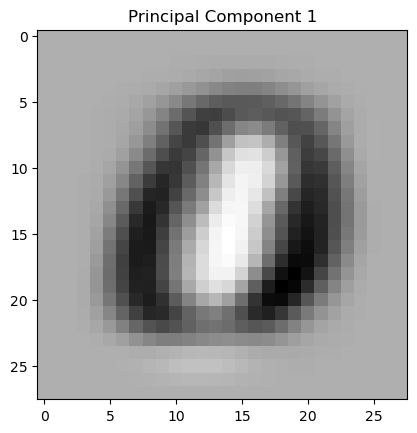

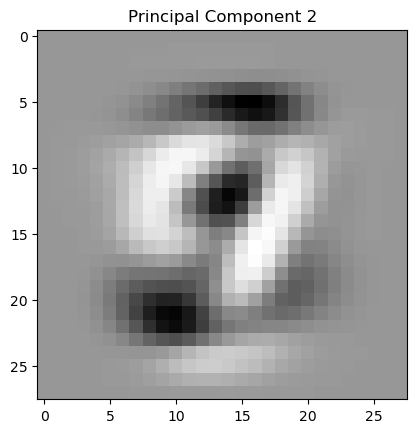

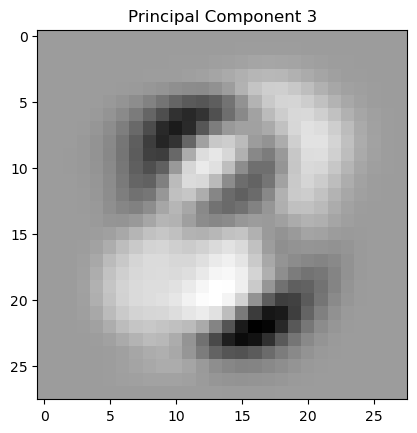

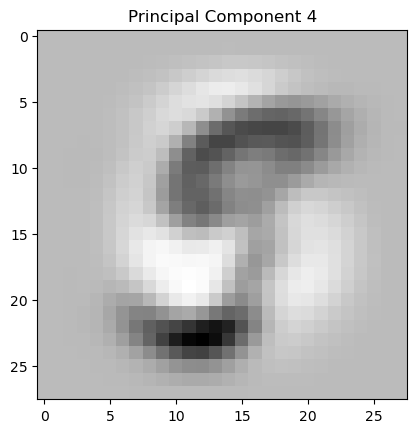

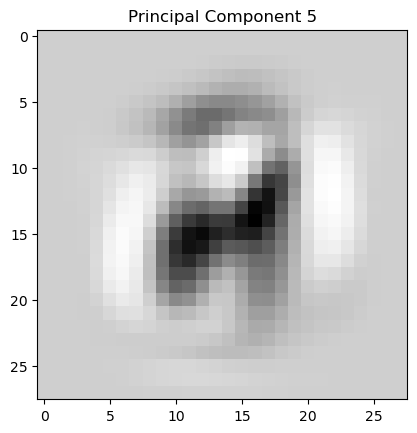

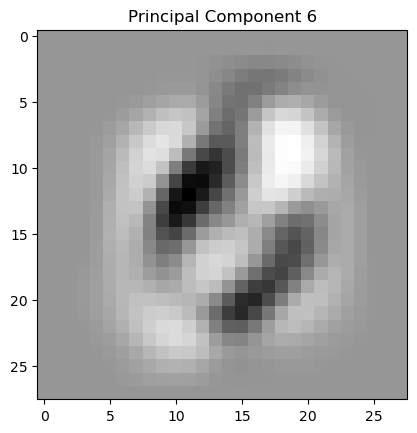

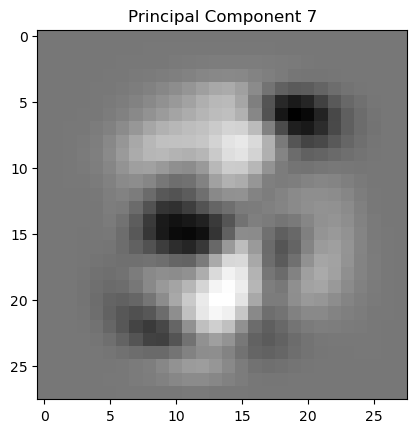

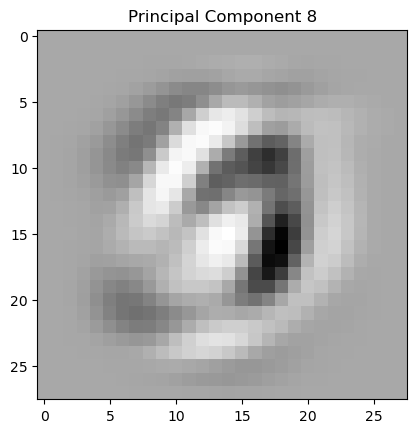

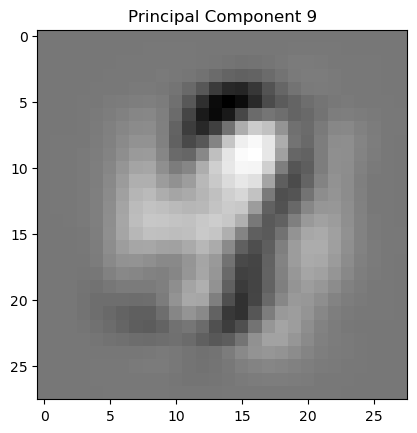

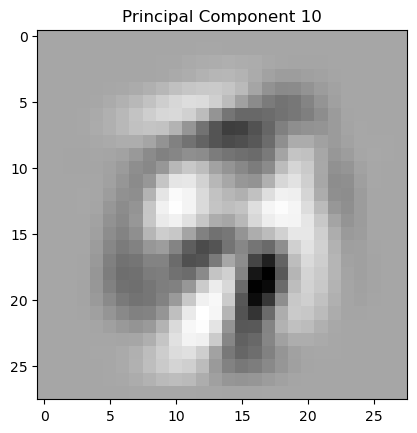

In [13]:
#Q3
for i in range(10):
    pc = pve_10_eig_vec[:, i].reshape(28, 28)
    min_val = pc.min()
    max_val = pc.max()
    pc_scaled = (pc - min_val) / (max_val - min_val)
    plt.imshow(pc_scaled, cmap='Greys_r')
    plt.title(f'Principal Component {i+1}')
    plt.show()

Q4-Project the first 100 images of the dataset onto the first 2 principal components.
Plot the projected data points on the 2-D space by coloring them according to the labels provided in the
dataset. Label the axes by the index of their corresponding principal components. Each digit label should
be colored with a different color, 10 colors in total.

Now I will project 100 images with 2 principal components

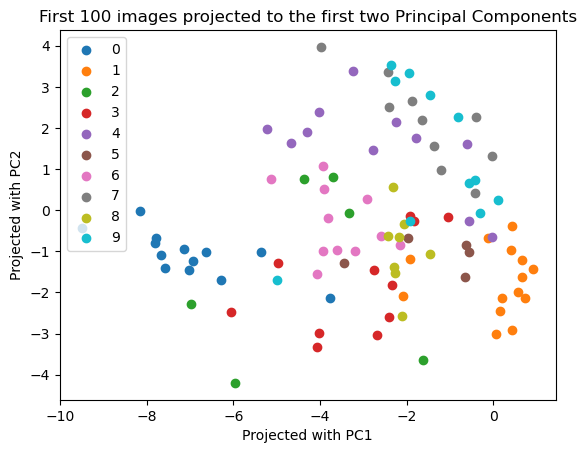

In [14]:
import numpy as np
import matplotlib.pyplot as plt

projected_data = np.dot(images[:100], eig_vec[:, :2])

unique_labels = np.unique(labels[:100])

for label in unique_labels:
    x_vals = []
    y_vals = []
    for i in range(100):
        if labels[i] == label:
            x_vals.append(projected_data[i, 0])
            y_vals.append(projected_data[i, 1])

    plt.scatter(x_vals, y_vals, label=label)

plt.title("First 100 images projected to the first two Principal Components")
plt.xlabel("Projected with PC1")
plt.ylabel("Projected with PC2")

plt.legend()

plt.show()


Q5-Describe how you can reconstruct an original digit image using the principal
components found in Question 1.1. Use first k principal components to analyze and reconstruct the first
image1 in the dataset where k ∈ {1, 50, 100, 250, 500, 784}. Discuss your results.

In [15]:
images.shape,eig_vec[:,:2].shape

((60000, 784), (784, 2))

In [16]:
def reconstruction(images,eig_vec,k):
    mean_val = np.mean(images,axis = 0)
    cent_images = images - mean_val
    z = np.dot(cent_images,eig_vec[:, :k]) # project features to k dimension new shape(60k,k)
    new_images = np.dot(z, eig_vec[:, :k].T) #(60k,k)*(k,784) = (60k,784) which is original image
    new_images = new_images + mean_val
    return new_images

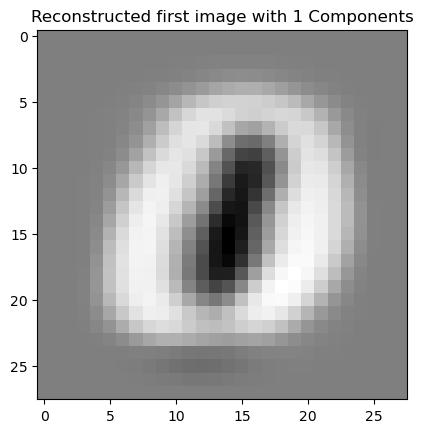

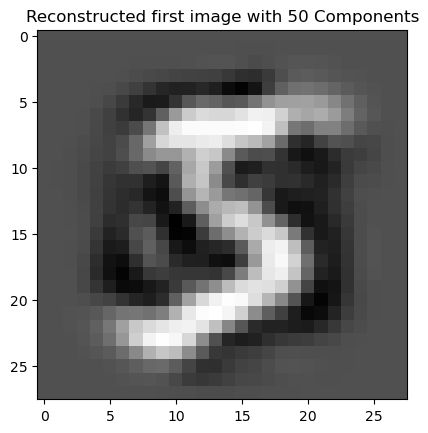

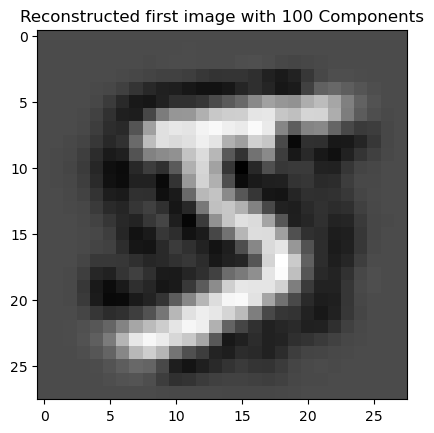

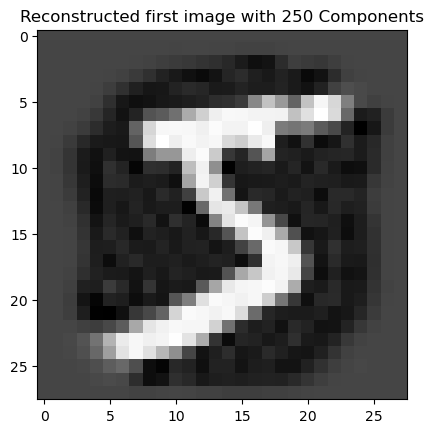

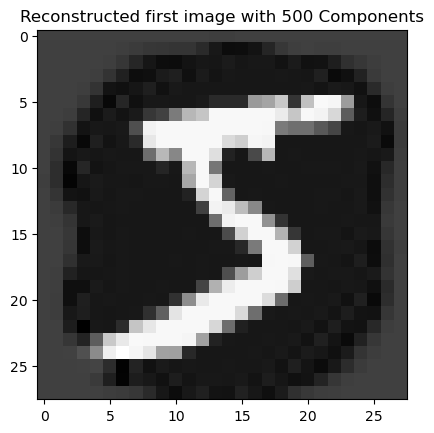

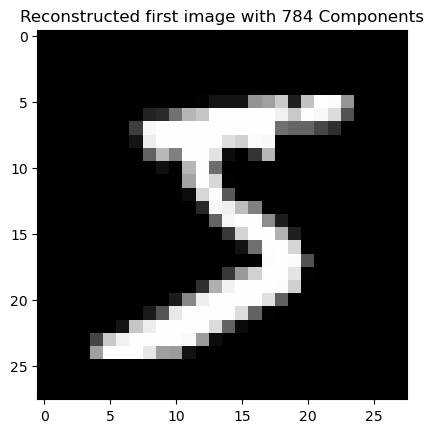

In [17]:
k = [1, 50, 100, 250, 500, 784]
for num in k:
    new_images = reconstruction(images[0],eig_vec,num)
    resized_im = new_images.reshape(28,28)
    plt.imshow(resized_im, cmap='Greys_r')
    plt.title(f'Reconstructed first image with {num} Components')
    plt.show()

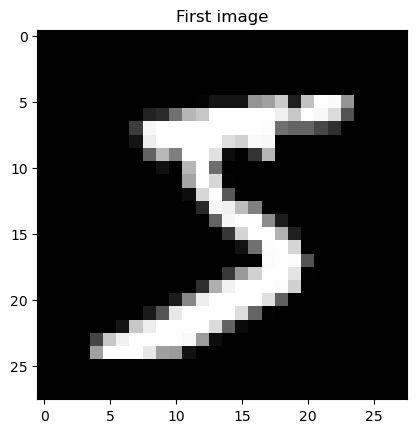

In [18]:
plt.imshow(images[0].reshape(28,28), cmap='Greys_r')
plt.title("First image")
plt.show()

# Question 2 - Logistic Regression

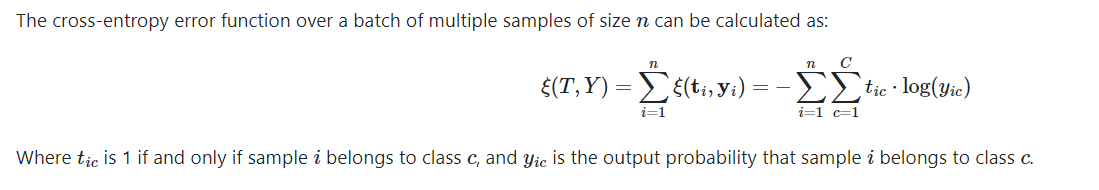

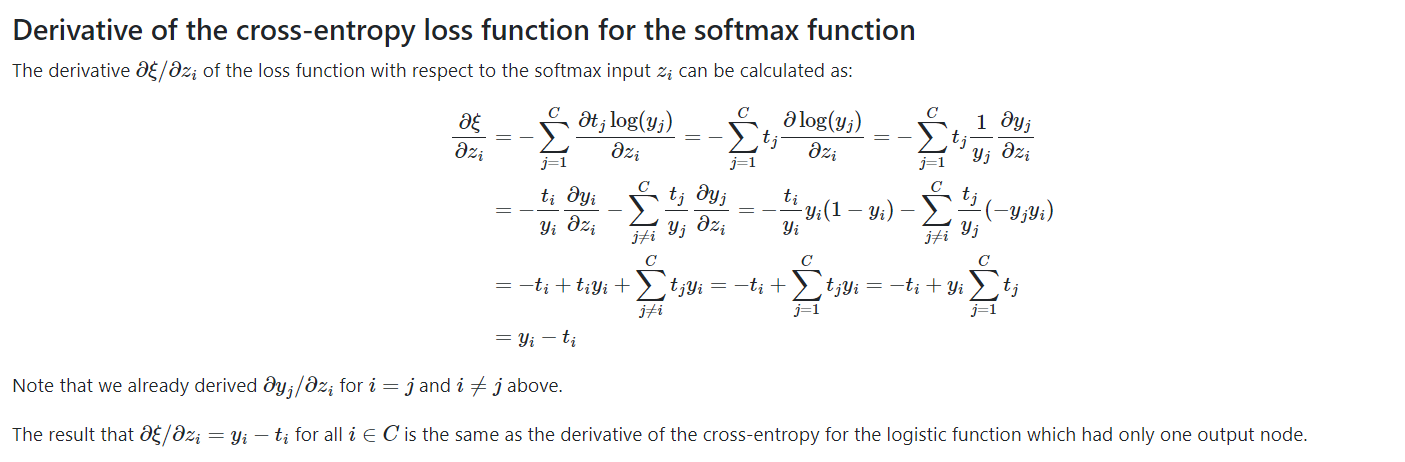

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import gzip

# One-hot encoding of the labels
def one_hot_encoding(label_data):
    num_label = len(label_data)
    encoded_labels = np.zeros((num_label,10),dtype =int)
    for i in range(num_label):
        label = label_data[i]
        encoded_labels[i,label] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1, 28*28)
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")
    
    X_val = X_train[:10000]
    y_val = y_train[:10000]
    
    X_train = X_train[10000:]
    y_train = y_train[10000:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [20]:
X_train,y_train,X_val,y_val,X_test,y_test = read_dataset()

In [21]:
X_train.shape,X_val.shape,X_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [22]:
y_train.shape,y_val.shape,y_test.shape

((50000, 10), (10000, 10), (10000, 10))

In [23]:
def softmax(v):
    e_v = np.exp(v - np.max(v, axis=1, keepdims=True))
    return e_v / np.sum(e_v, axis=1, keepdims=True) #keepdims allow us to work with different batch sizes

def cross_entropy_l2(y_true, y_pred, w, l2_lambda):
    e = 1e-12
    y_pred = np.clip(y_pred, e, 1 - e) # I add this to deal with log0 error
    cross_entropy = -np.sum(y_true * np.log(y_pred))
    l2_reg = (l2_lambda / 2) * np.sum(w ** 2)
    total_loss = cross_entropy + l2_reg
    return total_loss

def calc_gradients(X, y_true, y_pred, w, l2_lambda):
    grad_cross_entropy = np.dot(X.T, (y_pred - y_true))
    grad_l2 = l2_lambda * w
    dw = grad_cross_entropy + grad_l2
    db = np.sum(y_pred - y_true, axis=0)
    return dw,db


def init_w(size, init_method='normal'):
    if init_method == 'zeros':
        return np.zeros(size)
    elif init_method == 'uniform':
        return np.random.uniform(-1, 1, size)
    elif init_method == 'normal':
        return np.random.normal(0, 1, size)

In [24]:
class MultinomialLogisticRegression:
    def __init__(self,num_features, num_classes, l2_lambda, init_method='normal'):
        self.w = init_w((num_features, num_classes), init_method)
        self.b = init_w((num_classes,),init_method)
        self.l2_lambda = l2_lambda
    
    def predict_model(self, X):
        v = np.dot(X, self.w) + self.b
        o = softmax(v)
        return np.argmax(o, axis=1)
    
    def train_model(self, X_train, y_train,X_val,y_val, epochs=100, l_rate=5e-4, batch_size=200):
        num_samples = X_train.shape[0]
        accuracies = [] 

        for epoch in tqdm(range(epochs), desc="Training Progress", total=epochs, position=0, leave=True):
            ind = np.random.permutation(num_samples)
            X_mixed = X_train[ind]
            y_mixed = y_train[ind]

            for i in range(0, num_samples, batch_size):
                end = min(i + batch_size,X_train.shape[0])
                X_batch = X_mixed[i:end]
                y_batch = y_mixed[i:end]

                v = np.dot(X_batch, self.w) + self.b 
                o = softmax(v)
                loss = cross_entropy_l2(y_batch, o, self.w, self.l2_lambda)#We can use to track loss

                dw,db = calc_gradients(X_batch, y_batch, o, self.w, self.l2_lambda)
                self.w -= l_rate * dw
                self.b -= l_rate * db
            y_pred = self.predict_model(X_val)
            accuracy = np.mean(np.argmax(y_val, axis=1) == y_pred)
            accuracies.append(accuracy)

        return accuracies

In [25]:
num_features = X_train.shape[1]
num_classes = y_train.shape[1]
l2_lambda = 1e-4
l_rate = 5e-4
epochs = 100
batch_size = 200

model = MultinomialLogisticRegression(num_features, num_classes, l2_lambda)

model.train_model(X_train, y_train,X_val,y_val, epochs, l_rate,batch_size)

predictions = model.predict_model(X_test)

y_test_class = np.argmax(y_test, axis=1)

Training Progress: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


In [26]:
import numpy as np
import pandas as pd

def multi_class_metrics(y_pred, y_test):
    num_classes = 10
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(y_test)):
        true, pred = y_test[i], y_pred[i]
        confusion_matrix[true, pred] += 1

    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    f2 = np.zeros(num_classes)  # Initialize array for F2 scores

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        tn = np.sum(confusion_matrix) - (tp + fp + fn)

        if (tp+fp) != 0:
            precision[i] = tp/(tp+fp)
        else:
            precision[i] = 0
            
        if (tp+fn) != 0:
            recall[i] = tp/(tp+fn)
        else:
            recall[i] = 0
            
        if (precision[i]+recall[i]) != 0:
            f1[i] = 2*(precision[i]*recall[i]) / (precision[i]+recall[i])
        else:
            f1[i] = 0

        # Calculate F2 score
        if (4*precision[i] + recall[i]) != 0:
            f2[i] = 5*precision[i]*recall[i] / (4*precision[i] + recall[i])
        else:
            f2[i] = 0

    conf_matrix_df = pd.DataFrame(confusion_matrix, index=[f"True {i}" for i in range(num_classes)], columns=[f"Pred {i}" for i in range(num_classes)])
    
    metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'F2 Score': f2})
    metrics_df = metrics_df.T
    metrics_df.columns = [f"Class {i}" for i in range(num_classes)]

    return accuracy, precision, recall, f1, f2, conf_matrix_df, metrics_df


In [27]:
accuracy, precision, recall, f1,f2, conf_matrix_df_1,metrics_df_1 = multi_class_metrics(predictions, y_test_class)
conf_matrix_df_1

,Pred 0,Pred 1,Pred 2,Pred 3,Pred 4,Pred 5,Pred 6,Pred 7,Pred 8,Pred 9
True 0,941,0,2,3,0,21,6,3,4,0
True 1,0,1099,6,4,1,1,3,3,18,0
True 2,8,10,898,26,8,6,13,9,48,6
True 3,3,1,23,907,0,30,4,11,21,10
True 4,1,1,7,5,899,2,13,6,6,42
True 5,10,2,8,44,13,745,13,12,37,8
True 6,11,3,9,1,9,14,905,1,5,0
True 7,1,8,21,10,10,3,0,931,4,40
True 8,8,9,10,23,11,38,12,8,841,14
True 9,8,8,3,7,39,8,0,26,12,898


In [28]:
metrics_df_1

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Precision,0.949546,0.963190,0.909828,0.880583,0.908081,0.858295,0.933953,0.921782,0.844378,0.882122
Recall,0.960204,0.968282,0.870155,0.898020,0.915479,0.835202,0.944676,0.905642,0.863450,0.889990
F1 Score,0.954845,0.965729,0.889549,0.889216,0.911765,0.846591,0.939284,0.913641,0.853807,0.886038
F2 Score,0.958053,0.967259,0.877810,0.894477,0.913989,0.839720,0.942512,0.908825,0.859567,0.888405


In [29]:
print("Accuracy score for default model is",accuracy)

Accuracy score for default model is 0.9064


Now I will continue with the Question 2.2

Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Initialization method zeros training completed.


Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Initialization method uniform training completed.


Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]

Initialization method normal training completed.


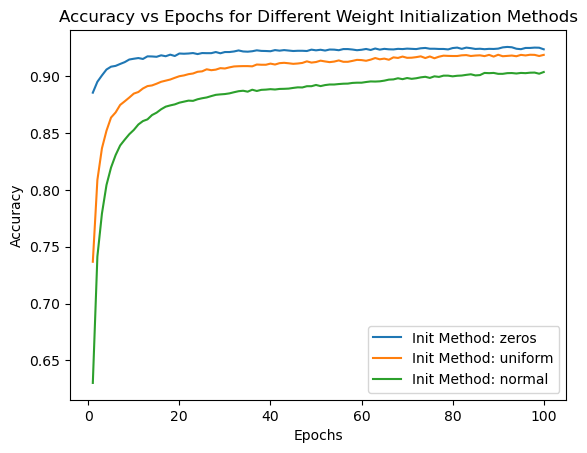

In [30]:
batch_sizes = [1, 64, 50000]
init_methods = ['zeros', 'uniform', 'normal']
learning_rates = [0.1, 1e-3, 1e-4, 1e-5]
regularization_coeffs = [1e-2, 1e-4, 1e-9]

#For checking the weight initialization methods assume other hyperparams constant
l2_lambda = 1e-4
batch_size = 64  
epochs = 100 

init_method_accuracies = {'zeros':[],'uniform':[],'normal':[]}

for init_method in init_methods:
    model = MultinomialLogisticRegression(num_features, num_classes, l2_lambda, init_method)
    
    accuracies = model.train_model(X_train, y_train,X_val,y_val, epochs, 5e-4, batch_size)
    init_method_accuracies[init_method] = accuracies
    print(f"Initialization method {init_method} training completed.")

plt.figure()
for init_method, accuracies in init_method_accuracies.items():
    plt.plot(range(1, epochs + 1), accuracies, label=f'Init Method: {init_method}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs for Different Weight Initialization Methods')
plt.legend()
plt.show()

Training Progress: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Learning rate 0.1 training completed.


Training Progress: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Learning rate 0.001 training completed.


Training Progress: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Learning rate 0.0001 training completed.


Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]

Learning rate 1e-05 training completed.


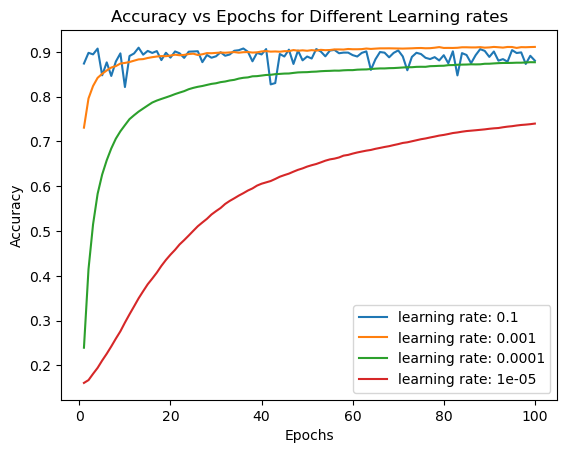

In [31]:
#For checking the weight initialization methods assume other hyperparams constant
l2_lambda = 1e-4
batch_size = 64  
epochs = 100
init_method = 'normal'

l_rate_accuracies = {0.1:[],1e-3:[],1e-4:[],1e-5:[]}

for l_rate in learning_rates:
    model = MultinomialLogisticRegression(num_features, num_classes, l2_lambda, init_method)
    
    accuracies = model.train_model(X_train, y_train,X_val,y_val, epochs, l_rate, batch_size)
    l_rate_accuracies[l_rate] = accuracies
    print(f"Learning rate {l_rate} training completed.")

plt.figure()
for l_rate, accuracies in l_rate_accuracies.items():
    plt.plot(range(1, epochs + 1), accuracies, label=f'learning rate: {l_rate}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs for Different Learning rates')
plt.legend()
plt.show()

Training Progress: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Regularization coefficient 0.01 training completed.


Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Regularization coefficient 0.0001 training completed.


Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]

Regularization coefficient 1e-09 training completed.


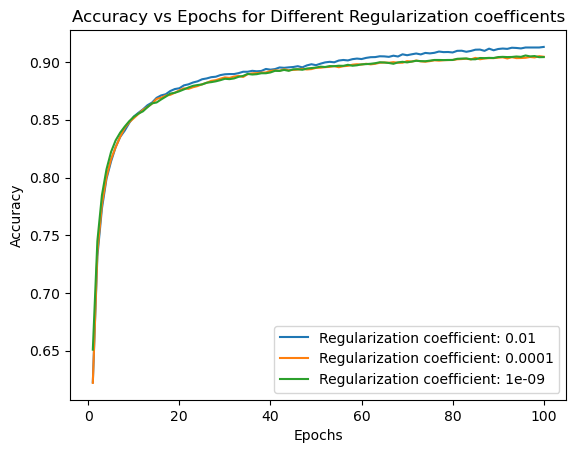

In [32]:
batch_size = 64  
epochs = 100
init_method = 'normal'
l_rate = 5e-4

reg_coef = {1e-2:[],1e-4:[],1e-9:[]}

for l2_lambda in reg_coef:
    model = MultinomialLogisticRegression(num_features, num_classes, l2_lambda, init_method)
    
    accuracies = model.train_model(X_train, y_train,X_val,y_val, epochs, l_rate, batch_size)
    reg_coef[l2_lambda] = accuracies
    print(f"Regularization coefficient {l2_lambda} training completed.")

plt.figure()
for l2_lambda, accuracies in reg_coef.items():
    plt.plot(range(1, epochs + 1), accuracies, label=f'Regularization coefficient: {l2_lambda}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs for Different Regularization coefficents')
plt.legend()
plt.show()

In [ ]:
epochs = 100
init_method = 'normal'
l_rate = 1e-3
l2_lambda = 1e-4

batch_sizes = {1:[],64:[],50000:[]}

for batch_size in batch_sizes:
    model = MultinomialLogisticRegression(num_features, num_classes, l2_lambda, init_method)
    
    accuracies = model.train_model(X_train, y_train,X_val,y_val, epochs, l_rate, batch_size)
    batch_sizes[batch_size] = accuracies
    print(f"Batch size {batch_size} training completed.")

plt.figure()
for batch_size, accuracies in batch_sizes.items():
    plt.plot(range(1, epochs + 1), accuracies, label=f'Batch size: {batch_size}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs for Different Batch Sizes')
plt.legend()
plt.show()

Training Progress:  31%|███       | 31/100 [14:30<32:23, 28.17s/it]

According to the observations, best performing model will have the following parameters:

Batch size = 64

Weight initialization method = zeros

Learning rate = 10^-3

Regularization coefficient = 0.01

In [34]:
num_features = X_train.shape[1]
num_classes = y_train.shape[1]
l2_lambda = 0.01
l_rate = 1e-3
epochs = 100
batch_size = 64

model_best = MultinomialLogisticRegression(num_features, num_classes, l2_lambda,init_method = 'zeros')

model_best.train_model(X_train, y_train,X_val,y_val, epochs, l_rate,batch_size)

predictions = model_best.predict_model(X_test)

y_test_class = np.argmax(y_test, axis=1)


Training Progress: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


In [35]:
accuracy, precision, recall, f1,f2, conf_matrix_df_best,metrics_df_best = multi_class_metrics(predictions, y_test_class)
conf_matrix_df_best

,Pred 0,Pred 1,Pred 2,Pred 3,Pred 4,Pred 5,Pred 6,Pred 7,Pred 8,Pred 9
True 0,961,0,1,3,0,6,6,2,1,0
True 1,0,1109,2,2,0,1,4,2,15,0
True 2,9,10,917,16,8,6,15,10,35,6
True 3,5,0,15,917,0,28,3,14,20,8
True 4,1,2,4,1,915,0,11,5,9,34
True 5,10,2,3,31,8,783,15,7,27,6
True 6,11,3,3,2,8,16,909,3,3,0
True 7,1,8,20,8,5,2,0,951,1,32
True 8,9,9,6,23,8,28,11,11,860,9
True 9,11,8,1,8,24,7,0,24,8,918


In [36]:
print("Accuracy score for best model is",accuracy)

Accuracy score for best model is 0.924


In [37]:
metrics_df_best

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Precision,0.944008,0.963510,0.943416,0.907023,0.937500,0.892816,0.933265,0.924198,0.878447,0.906219
Recall,0.980612,0.977093,0.888566,0.907921,0.931772,0.877803,0.948852,0.925097,0.882957,0.909812
F1 Score,0.961962,0.970254,0.915170,0.907472,0.934627,0.885246,0.940994,0.924648,0.880696,0.908012
F2 Score,0.973066,0.974345,0.899020,0.907741,0.932912,0.880765,0.945693,0.924917,0.882051,0.909091


In [38]:
model_best.w

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
model_best.w.shape


(784, 10)

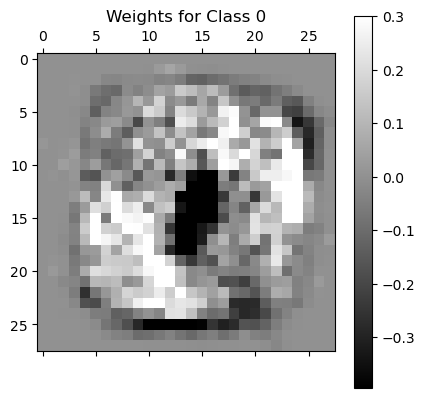

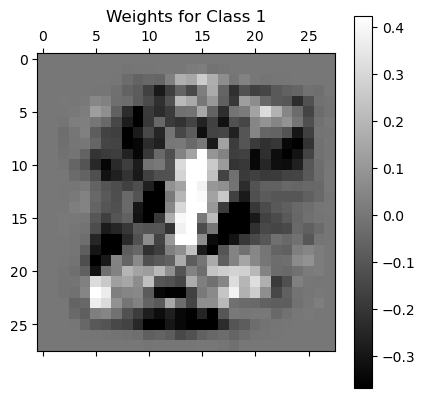

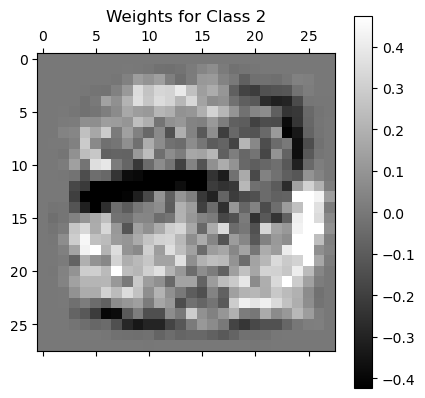

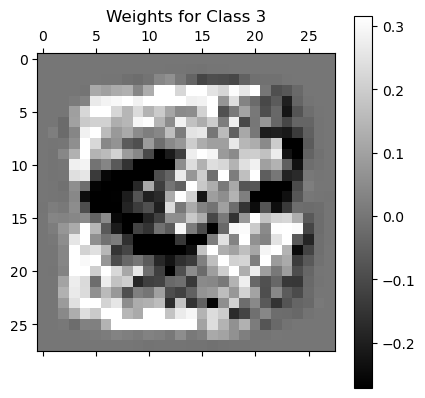

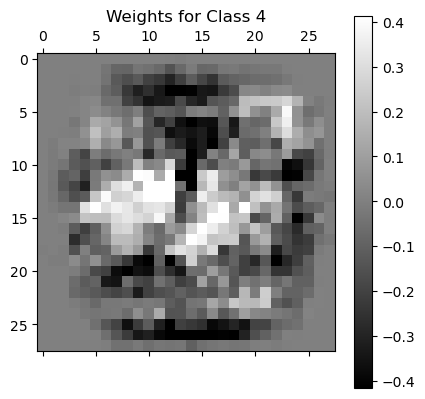

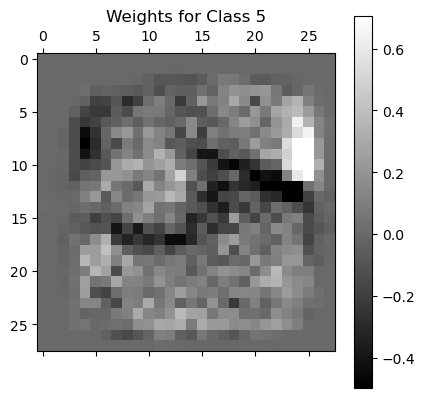

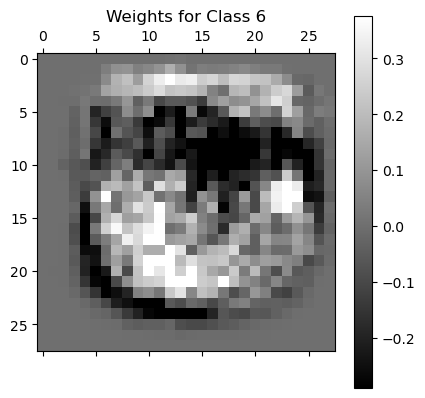

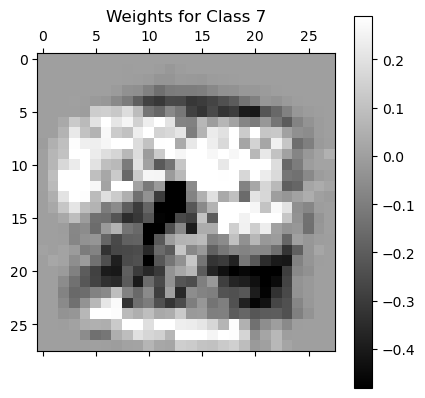

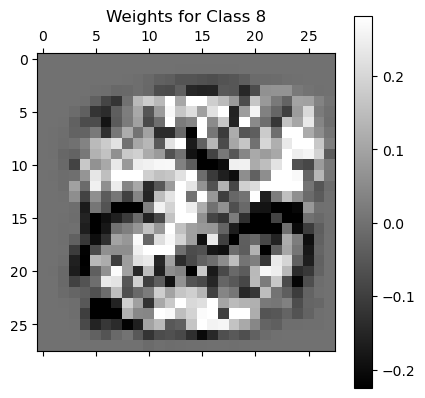

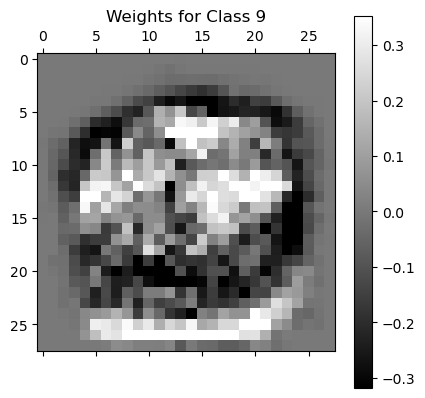

In [40]:
weight = model_best.w
for i in range(weight.shape[1]):
    weight_image = weight[:, i].reshape(28,28)
    plt.matshow(weight_image, cmap=plt.cm.gray, vmin=0.5*weight_image.min(), vmax=0.5*weight_image.max())
    plt.title(f'Weights for Class {i}')
    plt.colorbar()
    plt.show()